Epoch 1: Loss=0.2672, Accuracy=0.9615
Epoch 2: Loss=0.1103, Accuracy=0.9705
Epoch 3: Loss=0.0809, Accuracy=0.9680
Epoch 4: Loss=0.0611, Accuracy=0.9728
Epoch 5: Loss=0.0495, Accuracy=0.9758
Epoch 6: Loss=0.0388, Accuracy=0.9752
Epoch 7: Loss=0.0347, Accuracy=0.9757
Epoch 8: Loss=0.0301, Accuracy=0.9762
Epoch 9: Loss=0.0250, Accuracy=0.9765
Epoch 10: Loss=0.0222, Accuracy=0.9753


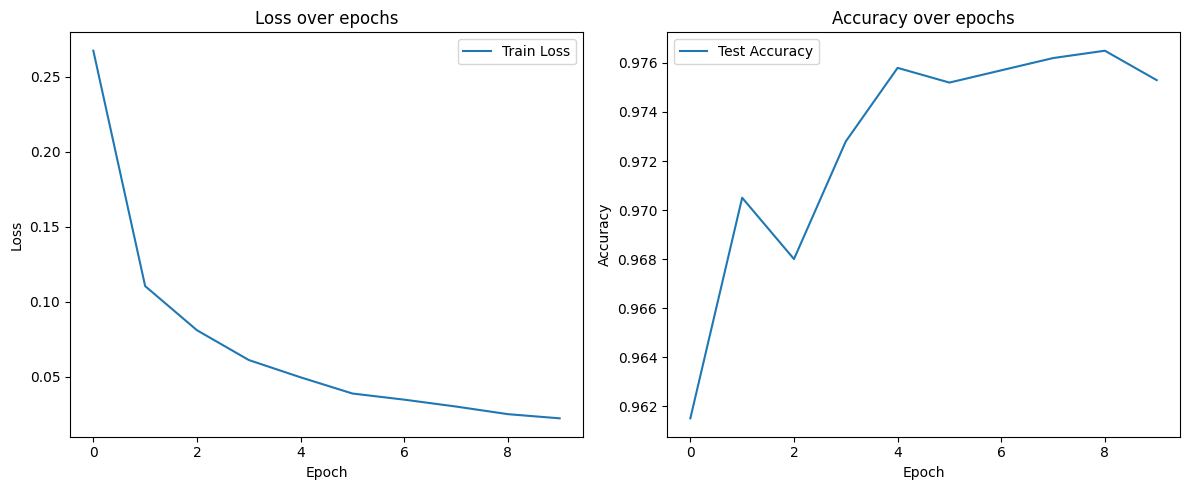

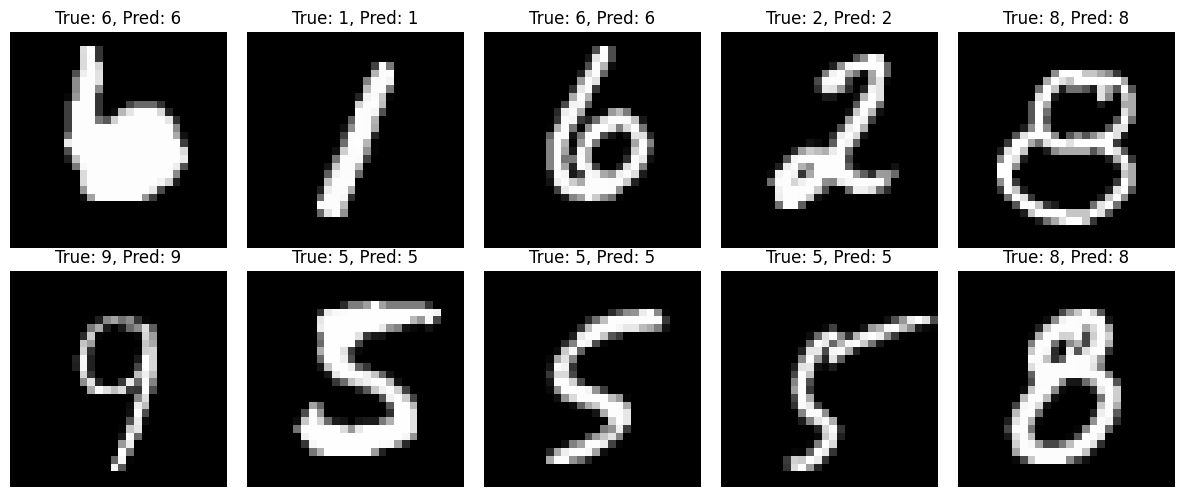

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)


class LinearNN(nn.Module):
    def __init__(self):
        super(LinearNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))


    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(test_dataset)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Accuracy={accuracy:.4f}")


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.tight_layout()
plt.show()


model.eval()
examples = random.sample(range(len(test_dataset)), 10)
plt.figure(figsize=(12,5))
for i, idx in enumerate(examples):
    image, label = test_dataset[idx]
    with torch.no_grad():
        img = image.to(device).unsqueeze(0)
        pred = model(img).argmax(dim=1).item()

    plt.subplot(2, 5, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {label}, Pred: {pred}")
    plt.axis('off')

plt.tight_layout()
plt.show()
